In [2]:
import torch
from torch.utils.data import Dataset
from typing import Tuple
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import copy
import torch
import torch.nn as nn
from torch.optim import Adam

from sklearn.metrics import roc_curve

In [7]:


#### LOADING THE MODEL

from torchvision.models import resnet18


device = "cpu"


model = resnet18(weights=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA_67.pt", map_location="cpu")

model.load_state_dict(ckpt)

model = model.to(device=device)
#### DATASETS

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform


    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label


    def __len__(self):
        return len(self.ids)


class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]


#data: MembershipDataset = torch.load("./priv_out.pt")

In [4]:
training_data: MembershipDataset = torch.load("./pub.pt")

In [5]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

transform = torchvision.transforms.Normalize(mean=mean, std=std)

# perform the transform on the images
training_data.transform = torchvision.transforms.Compose([
    transform
])

# threshold analysis

In [5]:

confidence_scores_original = []
confidence_scores_prediction = []

label_predicted = []
labels = []


memebership = []

model.eval()  # put model in evaluation mode

for i in range(len(data)):
    id_, img, label, member_status = data[i] # get image and label from dataset
    img=img.to(device=device)  # move image to device
    img = img.unsqueeze(0)  # add batch dimension
    score = model(img)  # get model's score
    score = score.to(device="cpu")  # move score to cpu
    confidence_score = torch.nn.functional.softmax(score, dim=1)

    label_pred = torch.argmax(confidence_score).item()


    confidence_scores_prediction.append(confidence_score[0][label_pred].item())
    confidence_scores_original.append(confidence_score[0][label].item())


    label_predicted.append(label_pred)
    labels.append(label)
    memebership.append(member_status)

In [6]:
# make a df with the results
df = pd.DataFrame(data={"label_predicted": label_predicted, "labels": labels, "memebership": memebership, "confidence_scores_original": confidence_scores_original, "confidence_scores_prediction": confidence_scores_prediction})
# save the df
df.to_csv("results_threshold.csv")

In [7]:
df = pd.read_csv("results_threshold.csv")

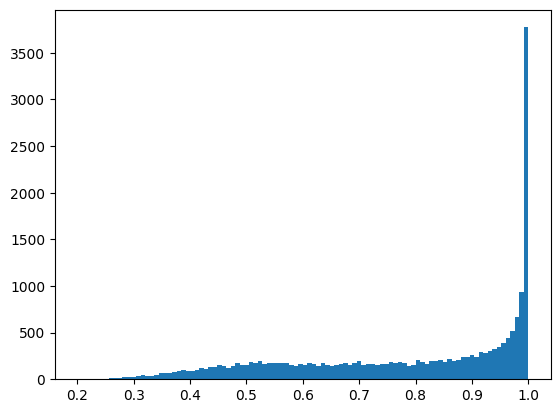

In [8]:
plt.hist(df['confidence_scores_prediction'],bins=100)
plt.show()

In [9]:
memebership

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,


C:\Users\HP\AppData\Local\Temp\ipykernel_6628\3524165839.py:31: RuntimeWarning: invalid value encountered in long_scalars
  precision_nm = tp_nm / (tp_nm + fp_nm)
C:\Users\HP\AppData\Local\Temp\ipykernel_6628\3524165839.py:36: RuntimeWarning: invalid value encountered in double_scalars
  f1_nm = 2 * (precision_nm * recall_nm) / (precision_nm + recall_nm)
C:\Users\HP\AppData\Local\Temp\ipykernel_6628\3524165839.py:28: RuntimeWarning: invalid value encountered in long_scalars
  precision_m = tp_m / (tp_m + fp_m)


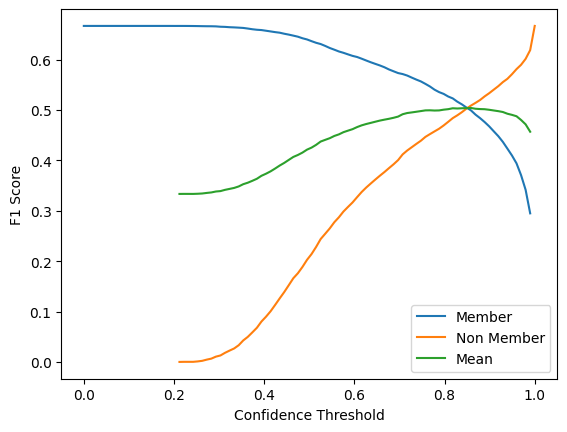

In [10]:
# Assuming `confidence_scores` is a list of confidence scores for each prediction,
# and `labels` is a list of true labels for each data point

# Convert lists to numpy arrays
confidence_scores = np.array(df["confidence_scores_prediction"])
memebership = np.array(df["memebership"])

# Calculate accuracy at different confidence thresholds
thresholds = np.linspace(0, 1, 100)
f1_scores_m = []
f1_scores_nm = []
mean_f1_scores = []

for threshold in thresholds:
    # Get predictions where confidence score is above the threshold
    preds = confidence_scores > threshold

    # Calculate TP, FP, and FN for each class
    tp_m = np.logical_and(preds, memebership==1).sum()
    fp_m = np.logical_and(preds, memebership==0).sum()
    fn_m = np.logical_and(~preds, memebership==1).sum()

    tp_nm = np.logical_and(~preds, memebership==0).sum()
    fp_nm = np.logical_and(~preds, memebership==1).sum()
    fn_nm = np.logical_and(preds, memebership==0).sum()

    # Calculate precision and recall for each class
    precision_m = tp_m / (tp_m + fp_m)
    recall_m = tp_m / (tp_m + fn_m)

    precision_nm = tp_nm / (tp_nm + fp_nm)
    recall_nm = tp_nm / (tp_nm + fn_nm)

    # Calculate F1 score for each class
    f1_m = 2 * (precision_m * recall_m) / (precision_m + recall_m)
    f1_nm = 2 * (precision_nm * recall_nm) / (precision_nm + recall_nm)

    # Calculate mean F1 score
    mean_f1 = (f1_m + f1_nm) / 2

    f1_scores_m.append(f1_m)
    f1_scores_nm.append(f1_nm)
    mean_f1_scores.append(mean_f1)

# Plot F1 score vs confidence threshold
plt.plot(thresholds, f1_scores_m, label="Member")
plt.plot(thresholds, f1_scores_nm, label="Non Member")
plt.plot(thresholds, mean_f1_scores, label="Mean")
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [11]:
mean_f1_scores = np.array(mean_f1_scores)
mean_f1_scores[np.isnan(mean_f1_scores)] = 0
best_threshold = thresholds[np.argmax(mean_f1_scores)]

In [12]:
best_threshold

0.8585858585858587

In [13]:
# threshold of 0.7845 , if greater than a member, if less than a non member.

In [14]:
# make prediction on test data priv_out.pt
data: MembershipDataset = torch.load("./priv_out.pt")

mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

transform = torchvision.transforms.Normalize(mean=mean, std=std)

# perform the transform on the images
data.transform = torchvision.transforms.Compose([
    transform
])


memebership = []

model.eval()  # put model in evaluation mode

for i in range(len(data)):
    id_, img, label, member_status = data[i] # get image and label from dataset
    img=img.to(device=device)  # move image to device
    img = img.unsqueeze(0)  # add batch dimension
    score = model(img)  # get model's score
    score = score.to(device="cpu")  # move score to cpu
    confidence_score = torch.max(torch.nn.functional.softmax(score, dim=1))

    memebership.append(confidence_score.item())

In [17]:
""" Do a memebership inference attack on the dataset. """

df = pd.DataFrame(
    {
        "ids": data.ids,
        "score": memebership,
    }
)
df.to_csv("test.csv", index=None)

In [18]:

response = requests.post("http://35.184.239.3:9090/mia", files={"file": open("test.csv", "rb")}, headers={"token": "75184352"}, timeout=100)
print(response.json())


ConnectionError: HTTPConnectionPool(host='35.184.239.3', port=9090): Max retries exceeded with url: /mia (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019F764A2E80>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

# Training Dataset memorization

We get rid of last layer for class prediction, then add a different layer which outputs 1 or 0 for member and non-memebr. We train only the last layer, while frezzing the weights of the previous layers. This to find if some part of the model memorizes the training dataset.

In [52]:
# find avaialble cuda devices
cuda = torch.cuda.is_available()
if cuda:
    print("cuda is available")
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

cuda is available
0
1
NVIDIA GeForce GTX 1650


In [53]:
device = "cuda:0"

In [54]:
# Load pre-trained model
model_copy = copy.deepcopy(model)


# Add new layer that outputs 1 or 0
model_copy.fc =  nn.Linear(512, 1)

# Freeze weights of previous layers
for param in model_copy.parameters():
    param.requires_grad = False

# Unfreeze weights of last layer
for param in model_copy.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.fc.parameters())

In [55]:
model_copy = model_copy.to(device=device)

In [94]:

num_epochs = 3
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    loss = 0.0
    for i in range(len(training_data)):
        id_, img, label, member_status = training_data[i] # get image and label from dataset
        img=img.to(device=device)  # move image to device
        img = img.unsqueeze(0)  # add batch dimension
        target = torch.tensor([[member_status]], dtype=torch.float32).to(device=device)  # convert member_status to tensor and move to device

        # Forward pass
        output = model_copy(img)  # get model's score
        loss += criterion(output, target)
    
        if i % batch_size == 0:
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = 0.0
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 0, Loss: 21.064292907714844
Epoch: 1, Loss: 21.064292907714844
Epoch: 2, Loss: 21.064292907714844


In [83]:
# predict on the test data
memebership = []
labels = []

model_copy.eval()  # put model in evaluation mode

for i in range(len(training_data)):
    id_, img, label, member_status = training_data[i] # get image and label from dataset
    img=img.to(device=device)  # move image to device
    img = img.unsqueeze(0)  # add batch dimension
    score = model_copy(img)  # get model's score
    score = score.to(device="cpu")  # move score to cpu
    confidence_score = torch.nn.functional.sigmoid(score)
    labels.append(member_status)

    memebership.append(confidence_score.item())

In [84]:
# accuracy between the predicted memebership and the true memebership
correct = 0
for i in range(len(memebership)):
    if memebership[i] > 0.5 and labels[i] == 1:
        correct += 1
    elif memebership[i] <= 0.5 and labels[i] == 0:
        correct += 1
print(correct/len(memebership))

0.4999


In [85]:
labels

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,


In [86]:
# find best threshold for the model
# Convert lists to numpy arrays
confidence_scores = np.array(memebership)
labels = np.array(labels)

# Calculate accuracy at different confidence thresholds
thresholds = np.linspace(0, 1, 100)
f1_scores_m = []
f1_scores_nm = []
mean_f1_scores = []

for threshold in thresholds:
    # Get predictions where confidence score is above the threshold
    preds = confidence_scores > threshold

    # Calculate TP, FP, and FN for each class
    tp_m = np.logical_and(preds, labels==1).sum()
    fp_m = np.logical_and(preds, labels==0).sum()
    fn_m = np.logical_and(~preds, labels==1).sum()

    tp_nm = np.logical_and(~preds, labels==0).sum()
    fp_nm = np.logical_and(~preds, labels==1).sum()
    fn_nm = np.logical_and(preds, labels==0).sum()

    # Calculate precision and recall for each class
    precision_m = tp_m / (tp_m + fp_m)
    recall_m = tp_m / (tp_m + fn_m)

    precision_nm = tp_nm / (tp_nm + fp_nm)
    recall_nm = tp_nm / (tp_nm + fn_nm)

    # Calculate F1 score for each class
    f1_m = 2 * (precision_m * recall_m) / (precision_m + recall_m)
    f1_nm = 2 * (precision_nm * recall_nm) / (precision_nm + recall_nm)

    # Calculate mean F1 score
    mean_f1 = (f1_m + f1_nm) / 2

    f1_scores_m.append(f1_m)
    f1_scores_nm.append(f1_nm)
    mean_f1_scores.append(mean_f1)

C:\Users\HP\AppData\Local\Temp\ipykernel_6628\600290983.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision_nm = tp_nm / (tp_nm + fp_nm)
C:\Users\HP\AppData\Local\Temp\ipykernel_6628\600290983.py:34: RuntimeWarning: invalid value encountered in double_scalars
  f1_nm = 2 * (precision_nm * recall_nm) / (precision_nm + recall_nm)
C:\Users\HP\AppData\Local\Temp\ipykernel_6628\600290983.py:26: RuntimeWarning: invalid value encountered in long_scalars
  precision_m = tp_m / (tp_m + fp_m)


In [87]:
precision_m

nan

In [91]:
# Plot F1 score vs confidence threshold

mean_f1_scores = np.array(mean_f1_scores)
mean_f1_scores[np.isnan(mean_f1_scores)] = 0
best_threshold = thresholds[np.argmax(mean_f1_scores)]


In [93]:
mean_f1_scores

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33364433, 0.33375536, 0.33375536, 0.33375536, 0.33395508,
       0.33402145, 0.33422096, 0.33455353, 0.33468564, 0.33526001,
       0.33565726, 0.33620456, 0.33690473, 0.33794568, 0.33939222,
       0.34111375, 0.34305171, 0.3450685 , 0.34983385, 0.35532118,
       0.36127775, 0.36671451, 0.37517963, 0.38613162, 0.39433761,
       0.40561374, 0.41802087, 0.43024782, 0.44195233, 0.45186153,
       0.46151951, 0.46854803, 0.47682876, 0.48262814, 0.48724225,
       0.48812475, 0.48896444, 0.49137015, 0.49314123, 0.49538398,
       0.49667564, 0.49915288, 0.50008507, 0.50164357, 0.50341884,
       0.50298994, 0.50275344, 0.50148903, 0.49848226, 0.49469607,
       0.48939225, 0.48264904, 0.47341661, 0.46464891, 0.45639535,
       0.4479007 , 0.43657896, 0.42538194, 0.41546449, 0.40708294,
       0.40137555, 0.39566537, 0.3883132 , 0.38385451, 0.37824

In [92]:
best_threshold

0.5454545454545455

# learn inputs from trained model.


we have a trained model, which we want to freeze all the weights and learn how the input should look like for each output. Then we can use these images for membership inference, if a test image looks similiar to a learnt image.

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [35]:
import torch
import torch.optim as optim

# Assume 'model' is your trained model and 'target_output' is the output you're interested in
target_output = torch.zeros(100, 44)
target_output[:, 0] = 1  # For example, let's say you're interested in the first output

# Initialize a random input
input = torch.randn(100, 3, 32, 32, requires_grad=True)

# Define an optimizer
optimizer = optim.Adam([input], lr=0.1)

# Optimize the input
for i in range(1000):
    optimizer.zero_grad()
    output = model(input)
    loss = ((output - target_output) ** 2).mean()
    loss.backward()
    optimizer.step()

# Now 'input' should be an approximation of the input that produces 'target_output'

In [36]:
summary_image = torch.mean(input,dim=0).detach().cpu().numpy()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


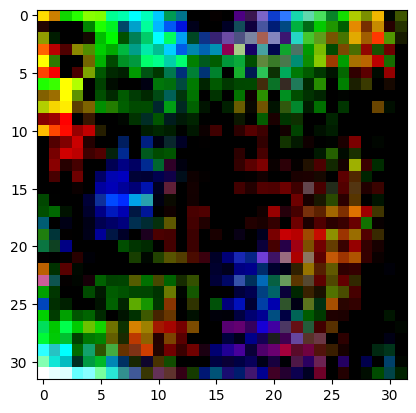

In [37]:
plt.imshow(summary_image.transpose(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


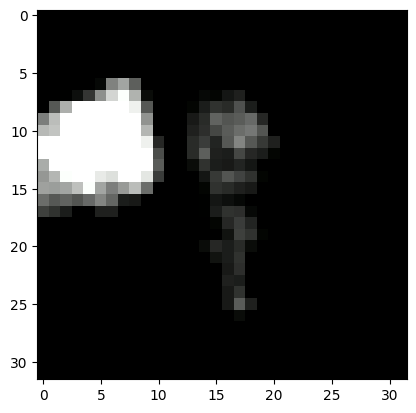

In [38]:
plt.imshow(img.squeeze().detach().numpy().transpose(1, 2, 0))


In [42]:
summary_image.shape,img.shape

((3, 32, 32), torch.Size([3, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


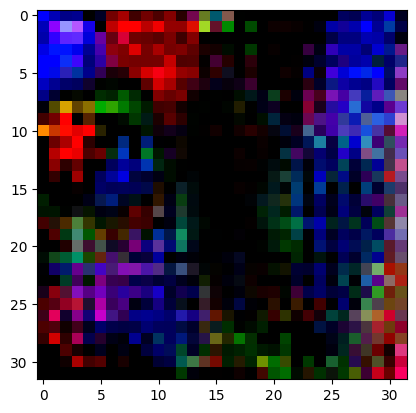

In [48]:
dot = summary_image * img.squeeze().detach().numpy()
plt.imshow(dot.transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


366 0
0.086577855


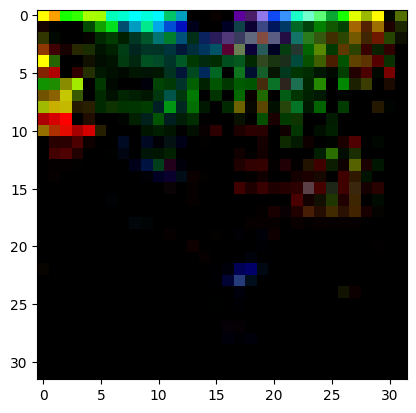

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1135 0
0.11490745


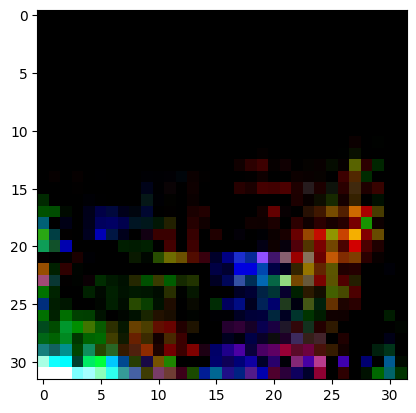

1429

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 0
0.08677912


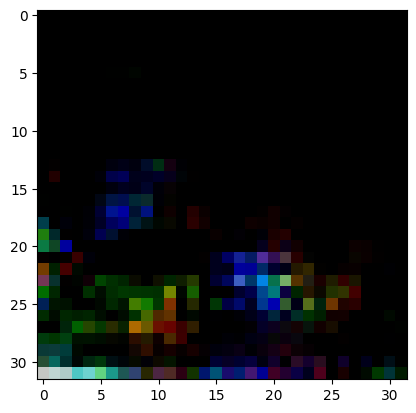

2377 1
0.08387215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


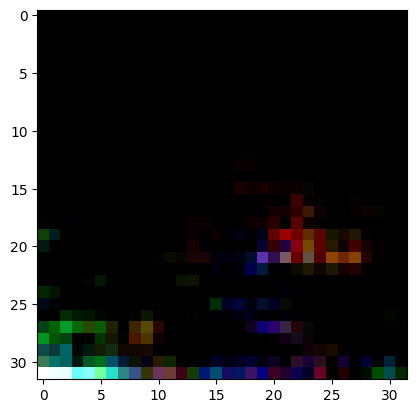

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2678 1
0.09481462


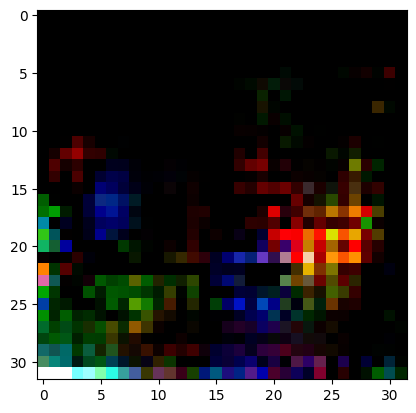

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3316 0
0.07117069


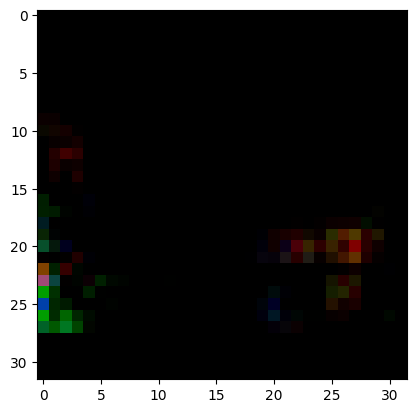

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3548 0
0.097382806


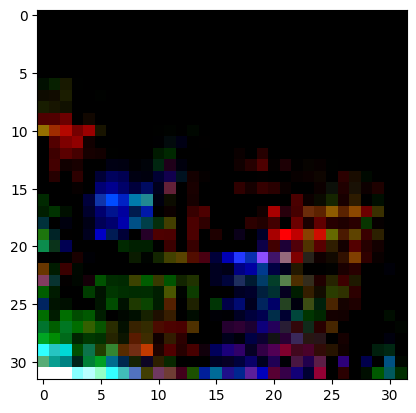

4691 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.056184784


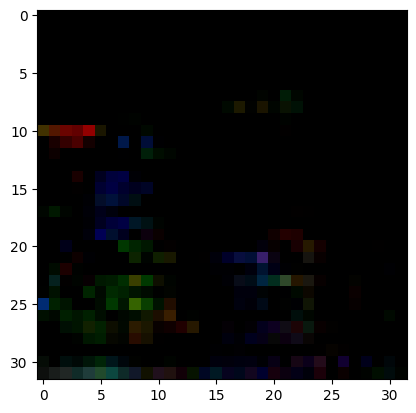

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7165 0
0.095571406


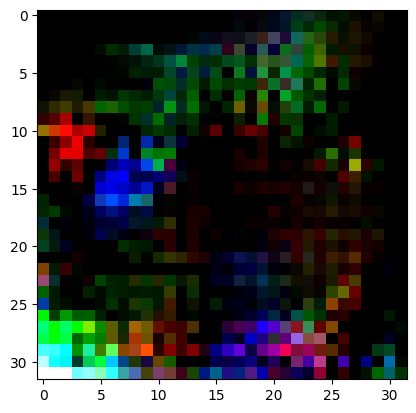

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7354 0
0.09312535


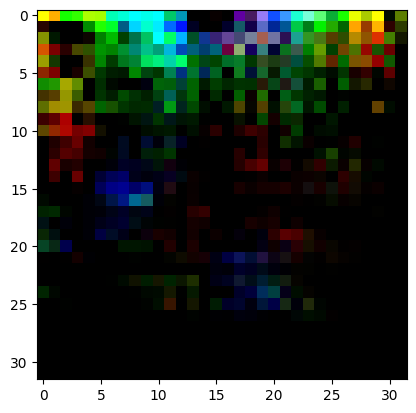

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7831 0
0.09911666


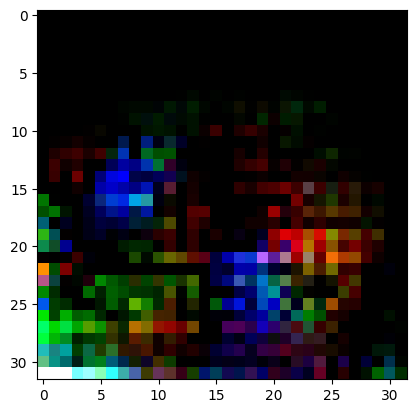

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8060 1
0.052655816


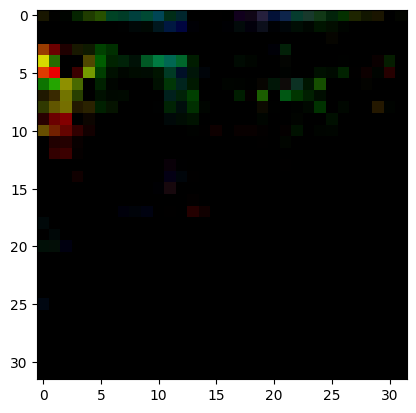

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8195 1
0.11001439


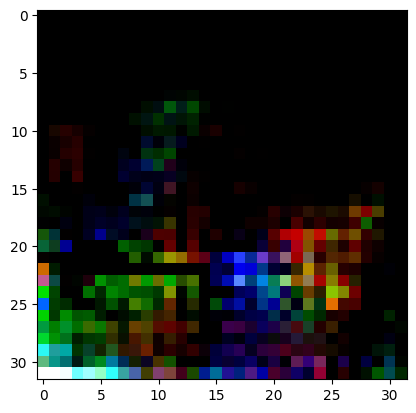

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8513 0
0.12616698


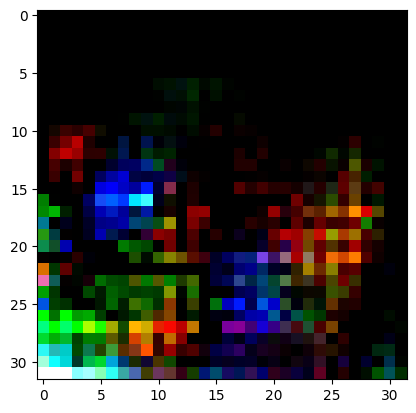

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8830 0
0.11434225


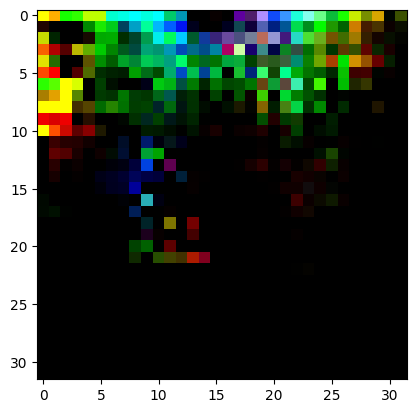

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9912 0
0.104040265


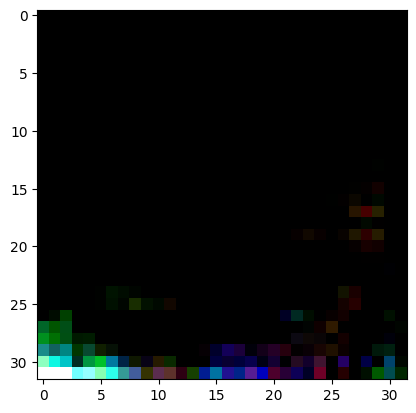

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11825 1
0.1145314


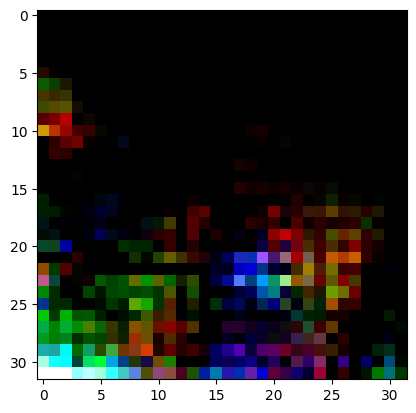

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12038 0
0.07429733


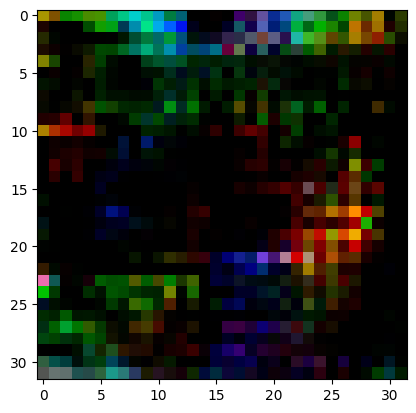

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13808 0
0.054443825


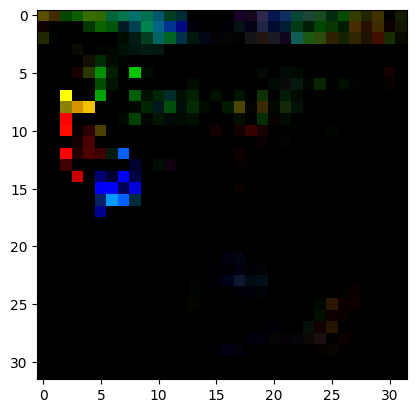

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14155 0
0.076621905


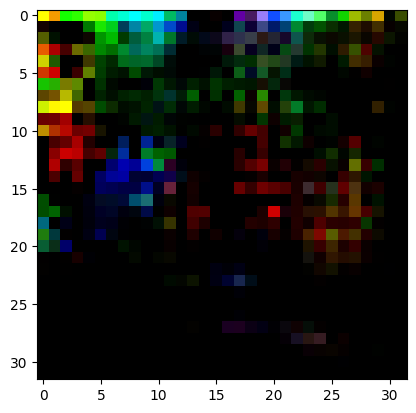

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14657 1
0.046527226


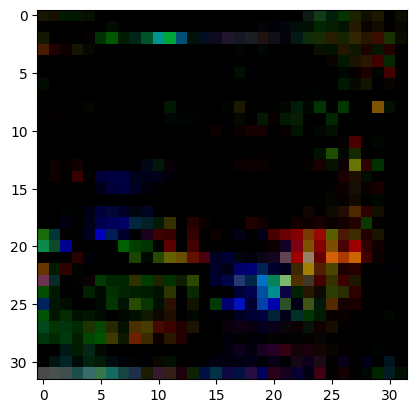

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15869 0
0.072211064


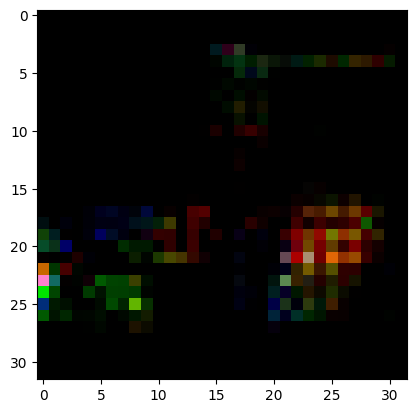

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16386 1
0.056394774


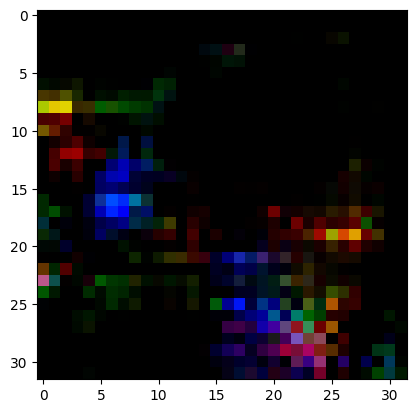

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16789 0
0.10635617


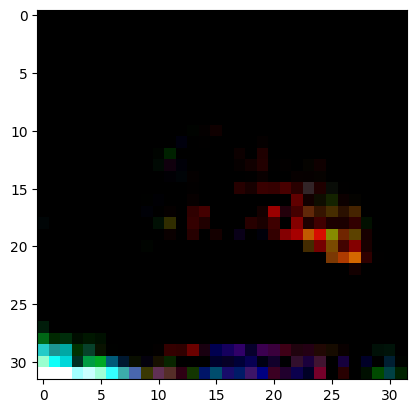

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17690 0
0.10313251


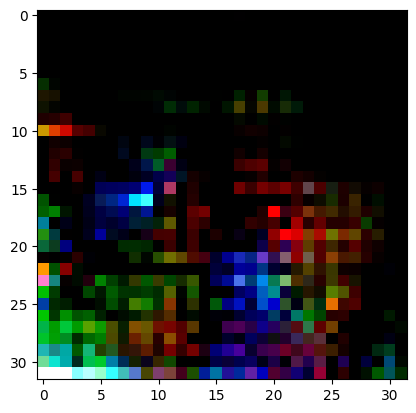

17854 1
0.12681733


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


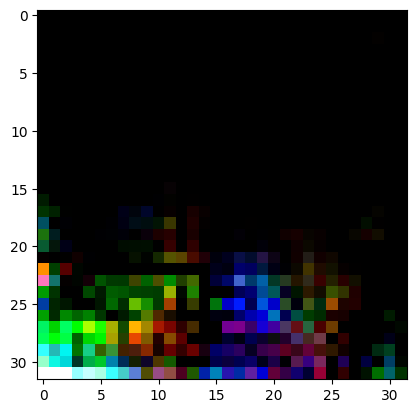

In [62]:


model.eval()  # put model in evaluation mode

for i in range(len(training_data)):
    id_, img, label, member_status = training_data[i] # get image and label from dataset
    if label == 0:

        print(i,member_status)

        # Calculate the SSIM between the test image and the generated image
        dot = (np.clip(summary_image,0,1) * img.squeeze().detach().numpy())
        
        print(np.mean(np.abs(dot)))
        
        plt.imshow(dot.transpose(1, 2, 0))
        plt.show()